<img src="https://pages.cnpem.br/workshopbioimagens/wp-content/uploads/sites/166/2023/06/logo-ilum-2048x382.png" alt="Descrição da imagem" style="width: 1000px; height: auto; ">


<div style=" padding: 10px; font-size: 36px; text-align: center;">
<strong>Processamento de Imagens:</strong> 
<div style=" padding: 10px; font-size: 27px; text-align: center;">
<strong>Imagens de raios-X para a detecção de Covid-19 🫁</strong> 

<div style=" padding: 10px; font-size: 17px; text-align: center;">
<strong>Autores: </strong>Júlia Guedes Almeida dos Santos e Yasmin Barbosa Shimizu
<div style=" padding: 10px; font-size: 17px; text-align: center;">
<strong>Professor:</strong> James Moraes de Almeida

### 📚 **Importação de bibliotecas**

In [2]:
# Gerais
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import seaborn as sns

# Scikit-image
from skimage import io
from skimage.filters import roberts, sobel, scharr, prewitt, farid, unsharp_mask

# Scikit-learn
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import shap

c:\Users\julia24002\.conda\envs\image_processing\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 🩻 **Importação dos dados e vetorização**

In [3]:
# Redimensiona o tamanho das imagens
TAMANHO = 128

#Transforma as imagens e os rótulos em arrays
treino_imagens = []
treino_rotulos = [] 

for diretorio in glob.glob("Dataset/Train/*"):
    rotulo = os.path.basename(diretorio)                
    # print("treino - rótulo", rotulo)
    # print("treino - diretorio", diretorio)

    for caminho in glob.glob(os.path.join(diretorio, "*.jpeg")):
        # print('treino', rotulo, caminho)
        img = cv2.imread(caminho, cv2.IMREAD_GRAYSCALE) # Leitura da imagem em preto e branco
        img = cv2.resize(img, (TAMANHO, TAMANHO)) # Redimensionamento das imagens
        treino_imagens.append(img)
        treino_rotulos.append(rotulo)

# print('treino_rotulos', treino_rotulos)                              

treino_imagens = np.array(treino_imagens)
treino_rotulos = np.array(treino_rotulos)


teste_imagens = []
teste_rotulos = [] 

for diretorio in glob.glob("Dataset/Val/*"):
    rotulo = os.path.basename(diretorio)                    
    # print("teste - rótulo", rotulo)
    # print("teste - diretorio", diretorio)
    for caminho in glob.glob(os.path.join(diretorio, "*.jpeg")):
        # print('teste', rotulo, caminho)
        img = cv2.imread(caminho, cv2.IMREAD_GRAYSCALE) #Reading color images
        img = cv2.resize(img, (TAMANHO, TAMANHO)) #Resize images
        teste_imagens.append(img)
        teste_rotulos.append(rotulo)
        
teste_imagens = np.array(teste_imagens)
teste_rotulos = np.array(teste_rotulos)

### 🔍**Escolhendo o melhor filtro**

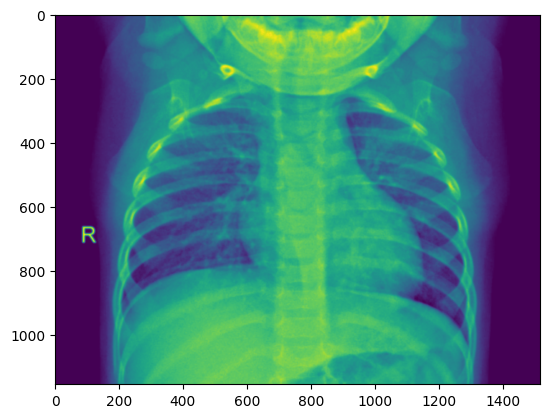

In [4]:
img_original = io.imread("Dataset/Train/Normal/IM-0151-0001.jpeg", as_gray=True)
plt.imshow(img_original)

Buscamos aqui por filtros que sejam capazes de reconhecer melhor as bordas presentes nas imagens (?)

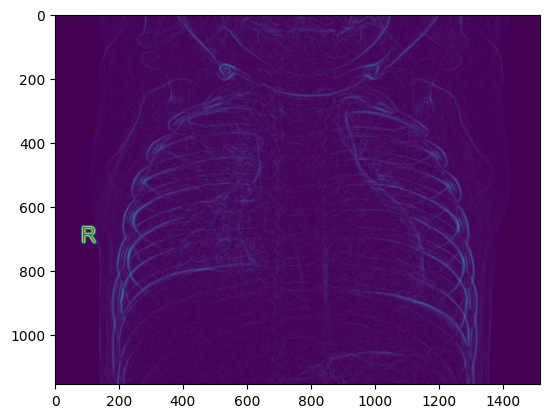

In [5]:
img_sobel = sobel(img_original)
plt.imshow(img_sobel)

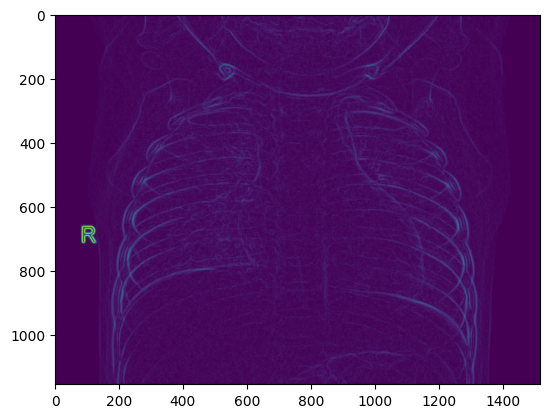

In [6]:
img_roberts = roberts(img_original)
plt.imshow(img_roberts)

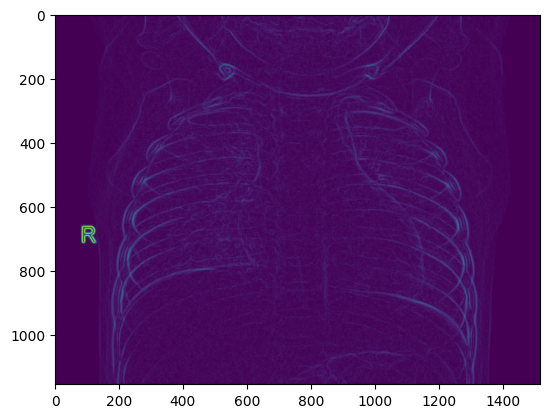

In [7]:
img_scharr = roberts(img_original)
plt.imshow(img_scharr)

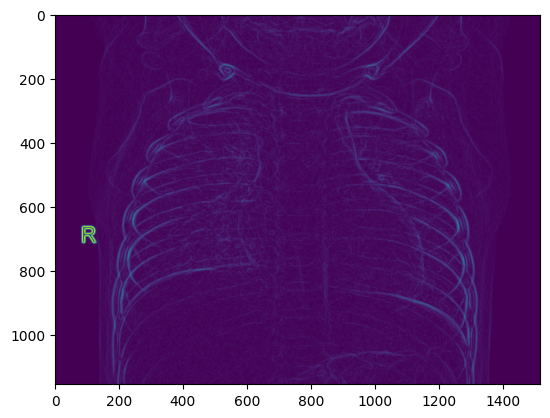

In [8]:
img_prewitt = prewitt(img_original)
plt.imshow(img_prewitt)

(np.float64(-0.5), np.float64(1517.5), np.float64(1155.5), np.float64(-0.5))

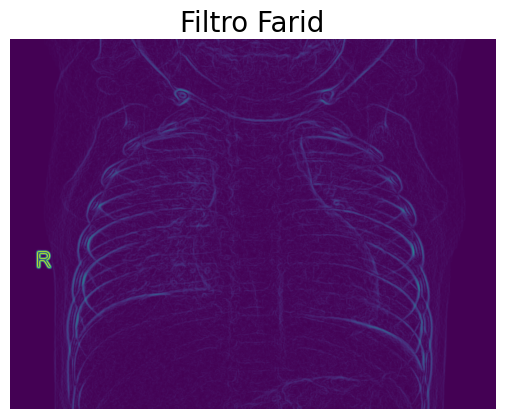

In [9]:
img_farid = farid(img_original)
plt.imshow(img_farid)
plt.title("Filtro Farid", fontsize=20)
plt.axis("off")

Text(0.5, 1.0, 'Imagem subtraída do filtro Unsharp')

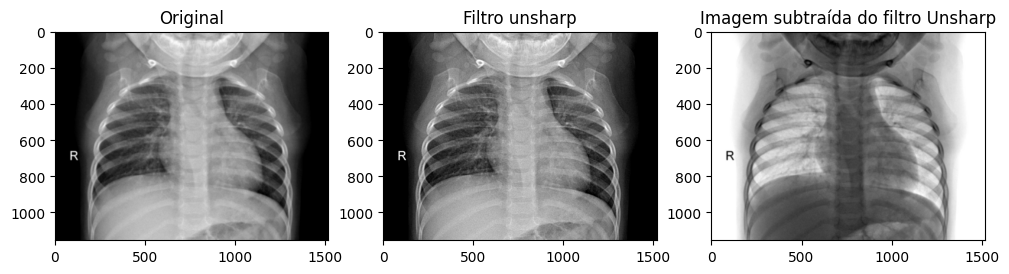

In [10]:
img_unsharp = unsharp_mask(img_original, radius=3, amount=2)
 
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
ax[0].imshow(img_original, cmap = "gray")
ax[0].set_title("Original")
ax[1].imshow(img_unsharp, cmap = "gray")
ax[1].set_title("Filtro unsharp")
ax[2].imshow(img_unsharp - img_original, cmap = "gray")
ax[2].set_title("Imagem subtraída do filtro Unsharp")

(np.float64(-0.5), np.float64(1517.5), np.float64(1155.5), np.float64(-0.5))

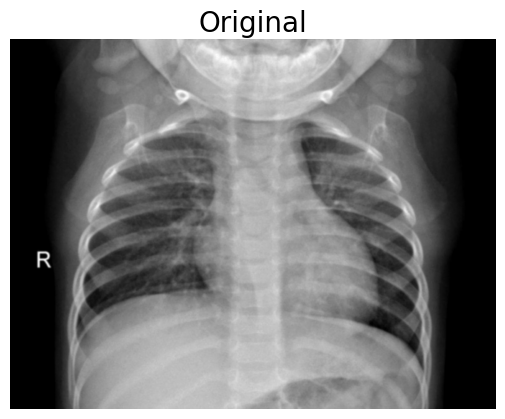

In [11]:
plt.imshow(img_original, cmap = "gray")
plt.title("Original", fontsize=20)
plt.axis("off")

### 💡 **Extração de Features**

In [12]:
def extracao_features(X_treino):

    dataset_final = pd.DataFrame()
    for imagem in range(X_treino.shape[0]):  
            
        df = pd.DataFrame() # Dataframe temporário para armazenar as informações de cada iteração
        img_entrada = X_treino[imagem, :,:] #,:]
        img = img_entrada

    ################################################################
    #                  ADIÇÃO DOS ATRIBUTOS AO DF                  #
    ################################################################
      
        # FEATURE 1 - Valores de Pixel 

        pixel_values = img.reshape(-1)
        df['Valor de Pixel'] = pixel_values   


        # FEATURE 2 - Respostas ao filtro de Galbor
        
        num = 1 
        kernels = []
        for theta in range(2):  
            theta = theta / 4. * np.pi
            # print(theta)
            # print()
            for sigma in (1, 3):
                #print(sigma)  
                lamda = np.pi/4
                gamma = 0.5
                gabor_label = 'Gabor' + str(num)  #Label Gabor columns as Gabor1, Gabor2, etc.

                ksize=9
                kernel = cv2.getGaborKernel((ksize, ksize), sigma, theta, lamda, gamma, 0, ktype=cv2.CV_32F)    
                kernels.append(kernel)

                fimg = cv2.filter2D(img, cv2.CV_8UC3, kernel)
                filtered_img = fimg.reshape(-1)
                df[gabor_label] = filtered_img  #Nome das colunas como Gabor1, Gabor2, etc.
                # print(gabor_label, ': theta=', theta, ': sigma=', sigma, ': lamda=', lamda, ': gamma=', gamma)
                num += 1  
                
         
        # FEATURE 3 - Farid
        filtro_farid = farid(img)
        filtro_farid = filtro_farid.reshape(-1)
        df['Farid'] = filtro_farid


        # FEATURE 4 - Unsharp
        filtro_unsharp = unsharp_mask(img)
        filtro_unsharp = filtro_unsharp - img
        filtro_unsharp = filtro_unsharp.reshape(-1)
        df['Unsharp'] = filtro_unsharp
       
        dataset_final = pd.concat([dataset_final, df], ignore_index=True)
        
    return dataset_final, kernels

In [13]:
atributos, kernels = extracao_features(treino_imagens)

n_features = atributos.shape[1]

image_features = np.expand_dims(atributos, axis=0)
X_treino = np.reshape(atributos, (treino_imagens.shape[0], -1))  


In [14]:
kernels[3].shape

(9, 9)

In [15]:
img_covid = io.imread("Dataset\Train\Covid\paving.jpg", as_gray=True)


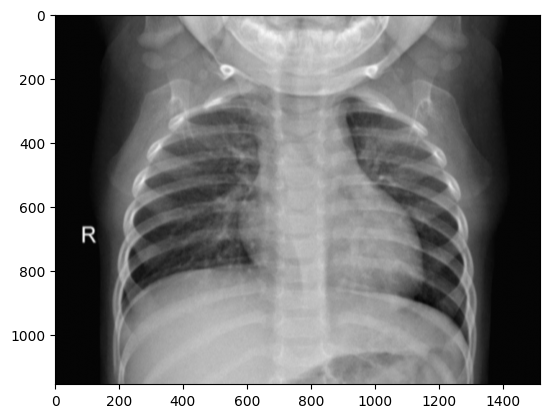

In [16]:
theta_0 = 0
sigma_0 = 1
lamda_0 = np.pi / 4
gamma_0 = 0.5
ksize_0 = 9

kernel_0 = cv2.getGaborKernel(
    (ksize_0, ksize_0),
    sigma_0,
    theta_0,
    lamda_0,
    gamma_0,
    0,
    ktype=cv2.CV_32F
)
gabor_0 = cv2.filter2D(img_covid, cv2.CV_32F, kernel_0)
gabor_1 = cv2.filter2D(img_original, cv2.CV_32F, kernel_0)
plt.imshow(gabor_1, cmap="gray")


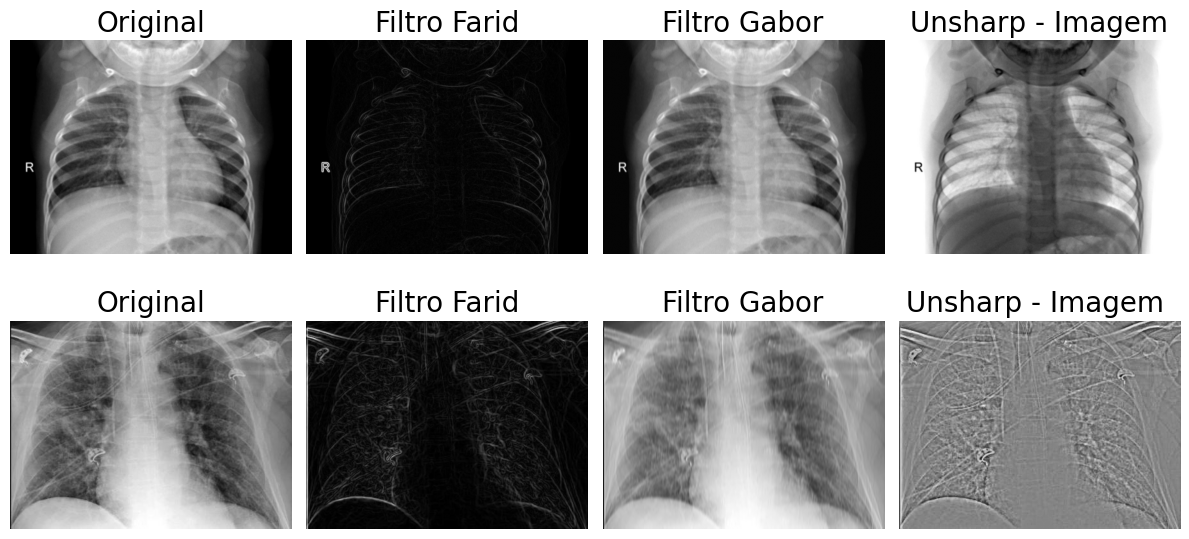

In [17]:
img_unsharp = unsharp_mask(img_original, radius=3, amount=2)

fig, ax = plt.subplots(2, 4, figsize=(12, 6))

# Normal
ax[0, 0].imshow(img_original, cmap="gray")
ax[0, 0].set_title("Original", fontsize=20)
ax[0, 0].axis("off")

ax[0, 1].imshow(img_farid, cmap="gray")
ax[0, 1].set_title("Filtro Farid", fontsize=20)
ax[0, 1].axis("off")

ax[0, 2].imshow(gabor_1, cmap="gray")
ax[0, 2].set_title("Filtro Gabor", fontsize=20)
ax[0, 2].axis("off")

ax[0, 3].imshow(img_unsharp - img_original, cmap="gray")
ax[0, 3].set_title("Unsharp - Imagem", fontsize=20)
ax[0, 3].axis("off")

# Covid
ax[1, 0].imshow(img_covid, cmap="gray")
#ax[1, 0].set_ylabel("Covid - 19")
ax[1, 0].set_title("Original", fontsize=20)
ax[1, 0].axis("off")

filtro_farid = farid(img_covid)
ax[1, 1].imshow(filtro_farid, cmap="gray")
ax[1, 1].set_title("Filtro Farid", fontsize=20)
ax[1, 1].axis("off")

kernel = cv2.getGaborKernel((9, 9), 1, 0, np.pi/4, 0.5, 0, ktype=cv2.CV_32F)  

filtro_gabor_cv = cv2.filter2D(img_covid, cv2.CV_32F, kernel_0)
ax[1, 2].imshow(filtro_gabor_cv, cmap="gray")
ax[1, 2].set_title("Filtro Gabor", fontsize=20)
ax[1, 2].axis("off")

filtro_unsharp = unsharp_mask(img_covid, radius=3, amount=2)
ax[1, 3].imshow(filtro_unsharp - img_covid, cmap="gray")
ax[1, 3].set_title("Unsharp - Imagem ", fontsize=20)
ax[1, 3].axis("off")

plt.tight_layout()
plt.show()

In [18]:
treino_imagens.shape

(196, 128, 128)

In [19]:
image_features.shape

(1, 3211264, 7)

In [20]:
X_treino.shape

(196, 114688)

In [21]:
X_treino[:,56083].shape

(196,)

In [22]:
atributos, kernels = extracao_features(teste_imagens)

n_features = atributos.shape[1]

image_features = np.expand_dims(atributos, axis=0)
X_teste = np.reshape(atributos, (teste_imagens.shape[0], -1))  

In [23]:
le = LabelEncoder()
y_treino = le.fit_transform(treino_rotulos)
y_teste = le.fit_transform(teste_rotulos)

### 💪 **Treinamento do modelo**

In [24]:
RF_model = RandomForestClassifier(random_state = 1025)

RF_model.fit(X_treino, y_treino)

RandomForestClassifier(random_state=1025)

### 🧐 **Avaliação de desempenho**

In [25]:
previsao = RF_model.predict(X_teste)

teste_previsao = le.inverse_transform(previsao)

Acurácia =  0.9772727272727273
Sensibilidade =  0.9666666666666667
Precisão 1.0


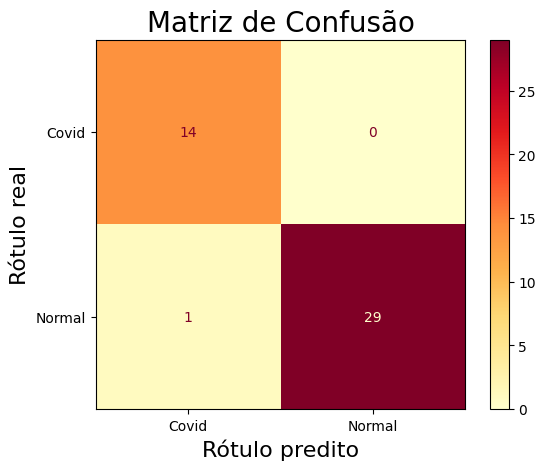

In [26]:
print ("Acurácia = ", metrics.accuracy_score(y_teste, previsao))
print("Sensibilidade = ", metrics.recall_score(y_teste, previsao))
print("Precisão", metrics.precision_score(y_teste, previsao))
 
cm = confusion_matrix(teste_rotulos, teste_previsao)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Covid', 'Normal'])
disp.plot(cmap=plt.cm.YlOrRd)
plt.rcParams['figure.dpi'] = 600   # ou 200, 300…
plt.title("Matriz de Confusão", fontsize=20)
plt.ylabel("Rótulo real", fontsize=16)
plt.xlabel("Rótulo predito", fontsize=16)
plt.show()
 

In [27]:
print("Rótulo real", "Previsão")
for i, j in zip(teste_rotulos, teste_previsao):
    print(i,j)

Rótulo real Previsão
Covid Covid
Covid Covid
Covid Covid
Covid Covid
Covid Covid
Covid Covid
Covid Covid
Covid Covid
Covid Covid
Covid Covid
Covid Covid
Covid Covid
Covid Covid
Covid Covid
Normal Normal
Normal Normal
Normal Normal
Normal Normal
Normal Normal
Normal Normal
Normal Normal
Normal Normal
Normal Normal
Normal Normal
Normal Normal
Normal Normal
Normal Normal
Normal Normal
Normal Normal
Normal Normal
Normal Normal
Normal Normal
Normal Normal
Normal Normal
Normal Normal
Normal Normal
Normal Normal
Normal Normal
Normal Normal
Normal Normal
Normal Normal
Normal Normal
Normal Normal
Normal Covid


In [28]:
img_errada = X_teste[-1].reshape(128, 128, 7)

img_original_errada = img_errada[:,:, 0]

Text(0.5, 1.0, 'FP do conjunto de teste')

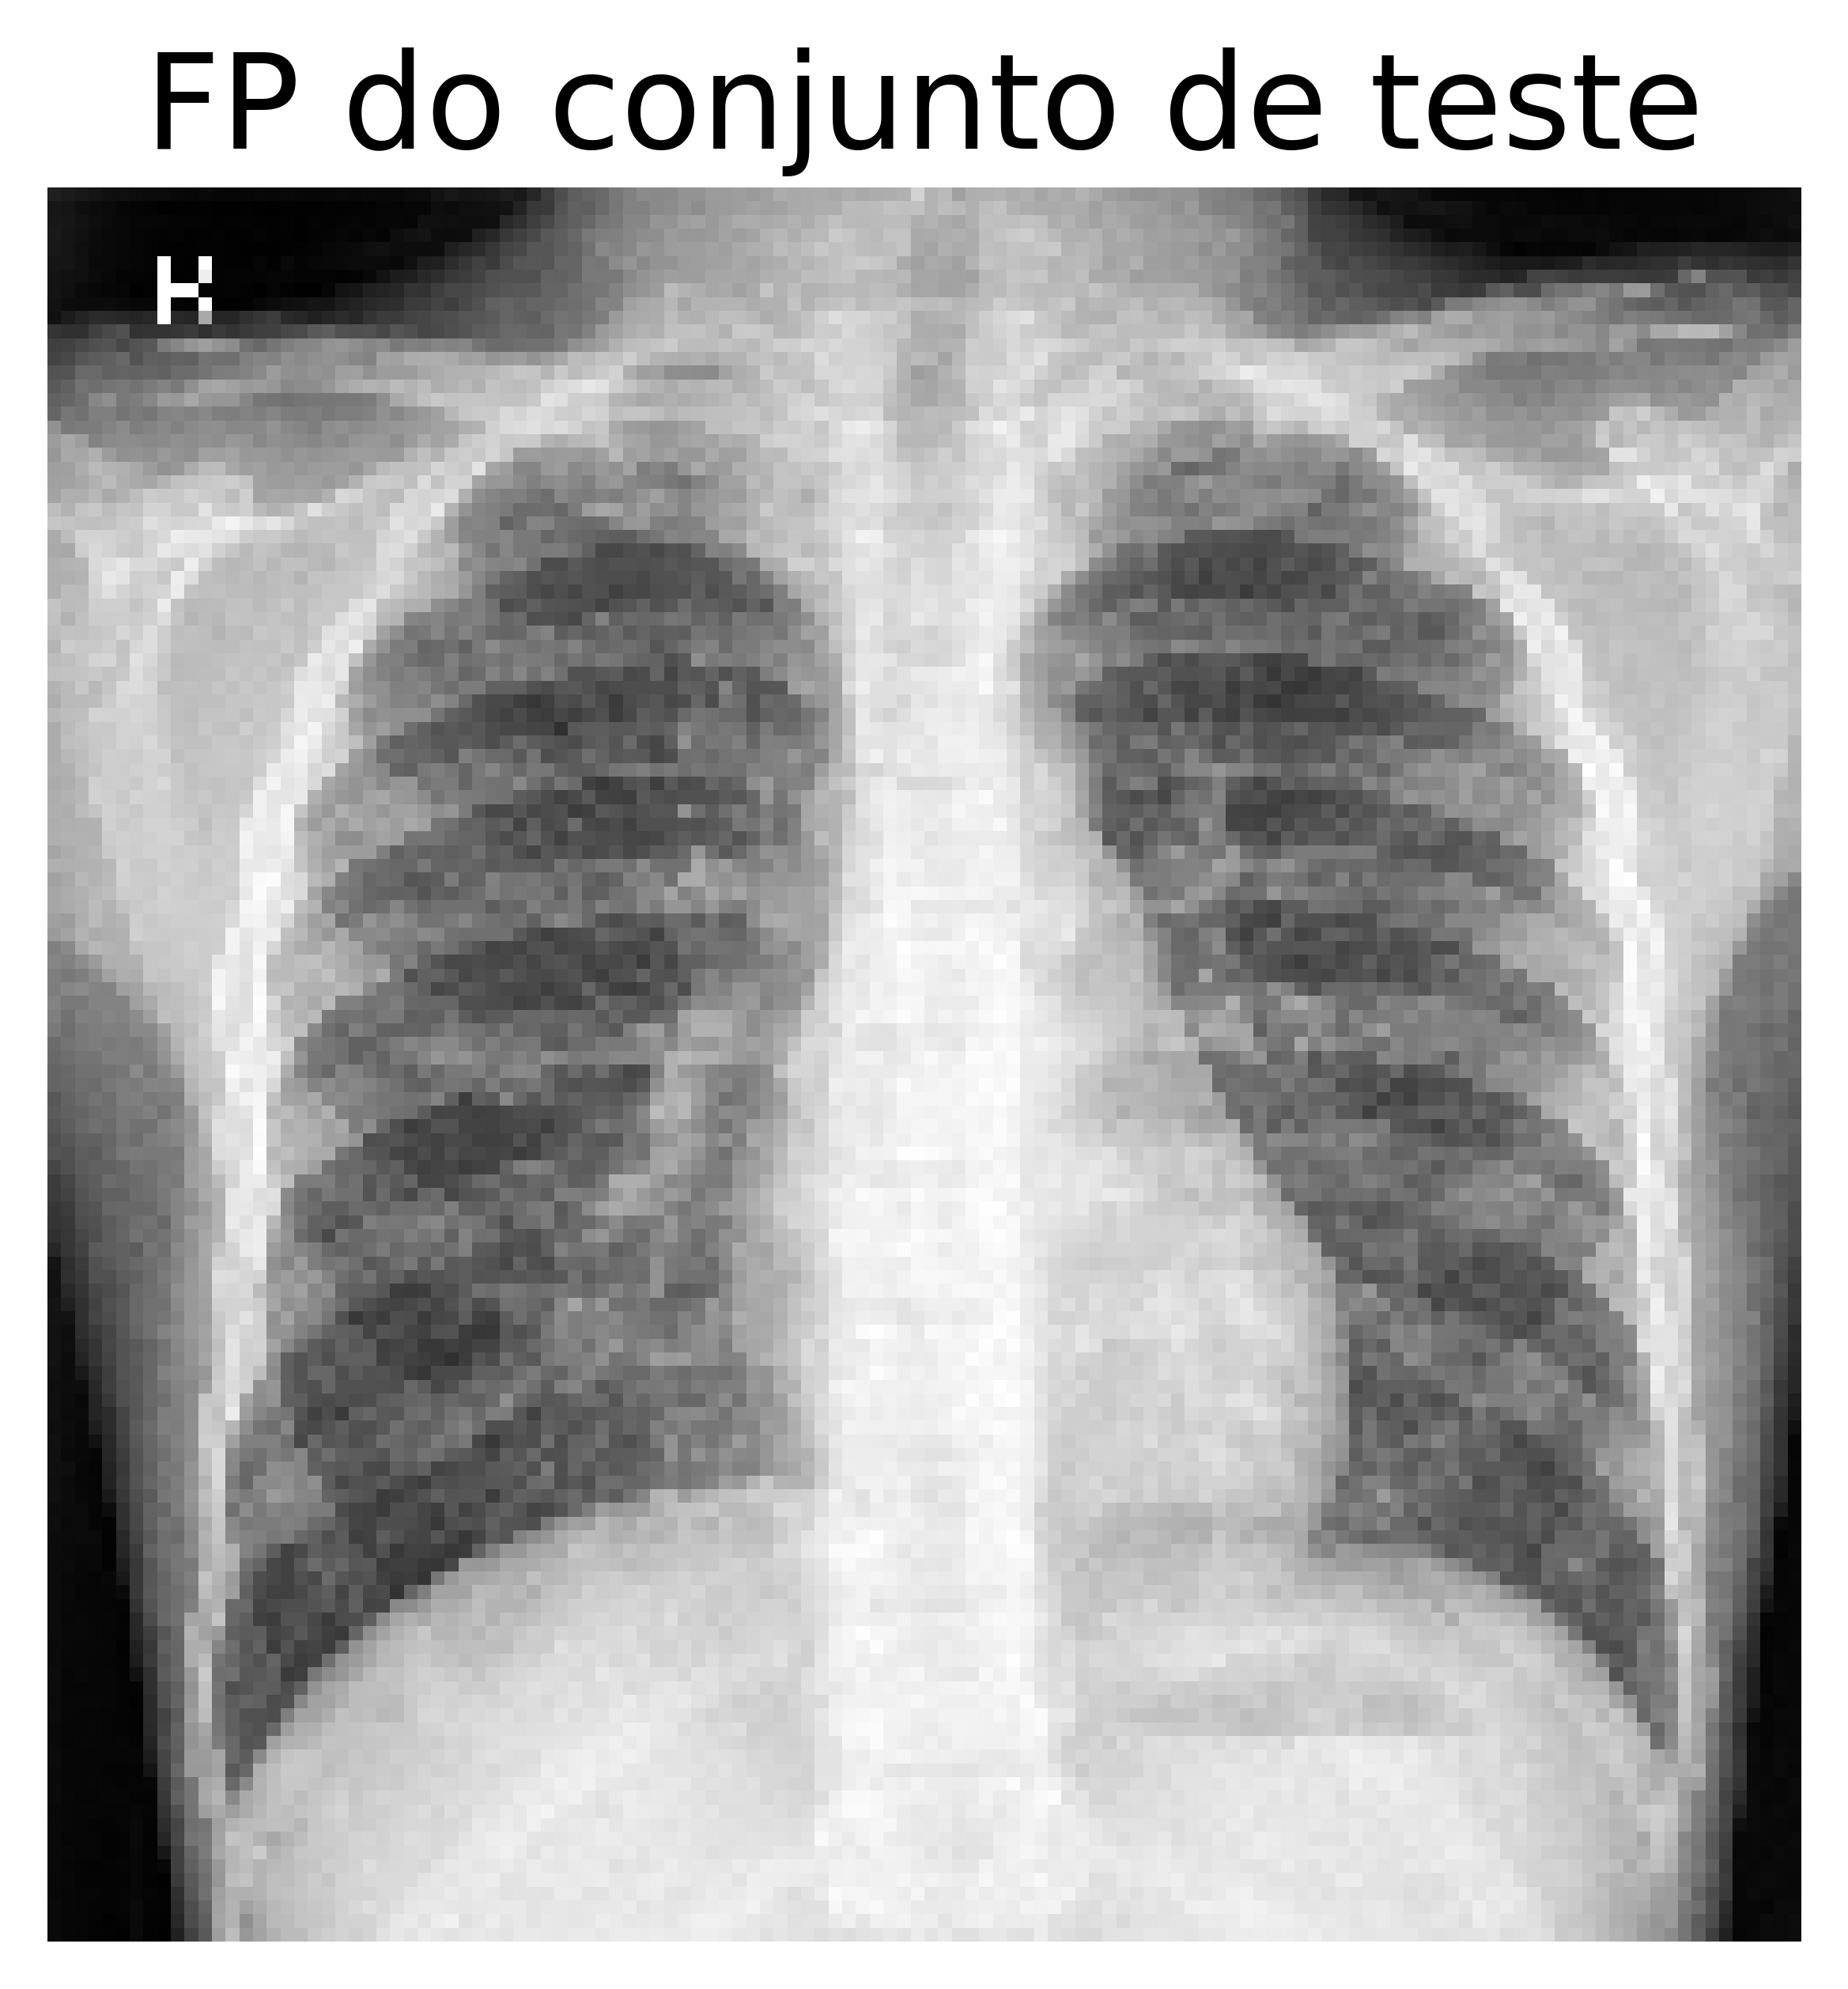

In [29]:
plt.imshow(img_original_errada, cmap="gray")
plt.rcParams['figure.dpi'] = 600  # aumenta a resolução da janela

plt.axis("off")
plt.title("FP do conjunto de teste", fontsize=20)

### 📝**Explicabilidade** 

##### Importância Global dos Pixels

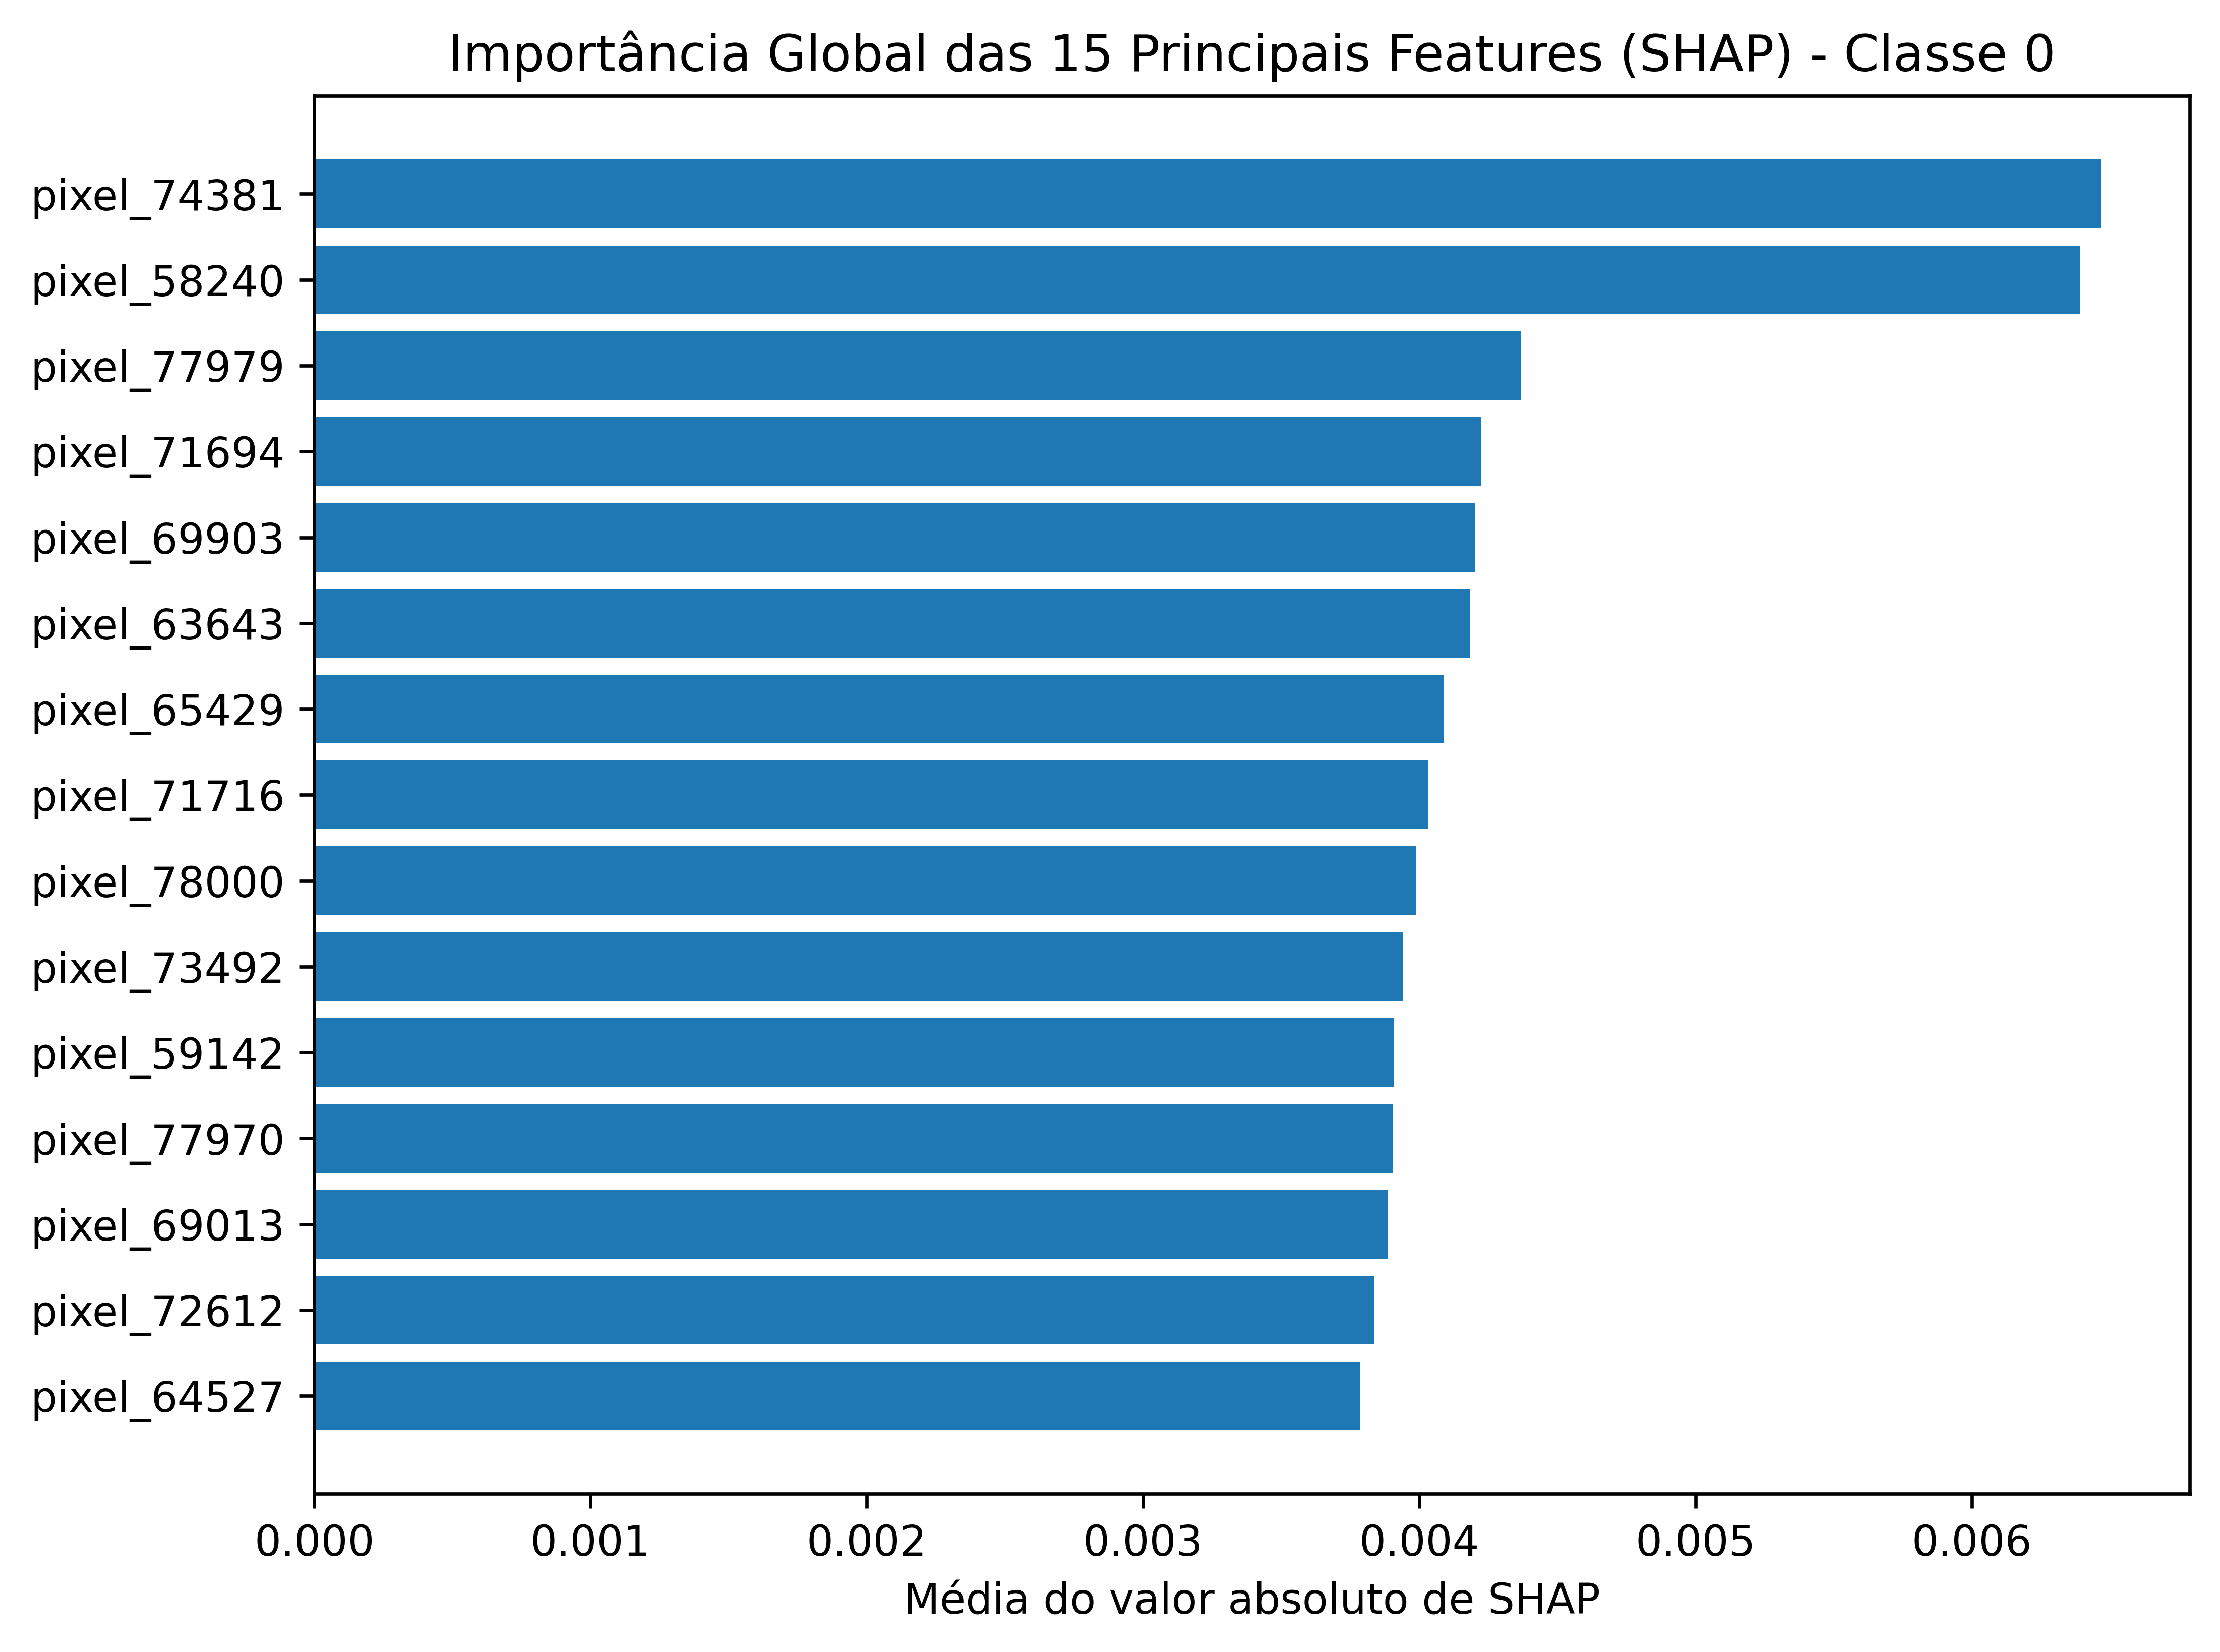

In [30]:
explainer = shap.TreeExplainer(RF_model)

shap_values = explainer(X_teste)
shap_values_class1 = shap_values[..., 0]  
mean_abs_shap = np.abs(shap_values_class1.values).mean(axis=0)
feature_names = [f"pixel_{i}" for i in range(len(mean_abs_shap))]


df_importance = pd.DataFrame({
    "Feature": feature_names,
    "Mean |SHAP|": mean_abs_shap
}).sort_values("Mean |SHAP|", ascending=False)

plt.figure(figsize=(8, 6))
plt.barh(df_importance["Feature"].head(15)[::-1], df_importance["Mean |SHAP|"].head(15)[::-1])
plt.title("Importância Global das 15 Principais Features (SHAP) - Classe 0")
plt.xlabel("Média do valor absoluto de SHAP")
plt.show()


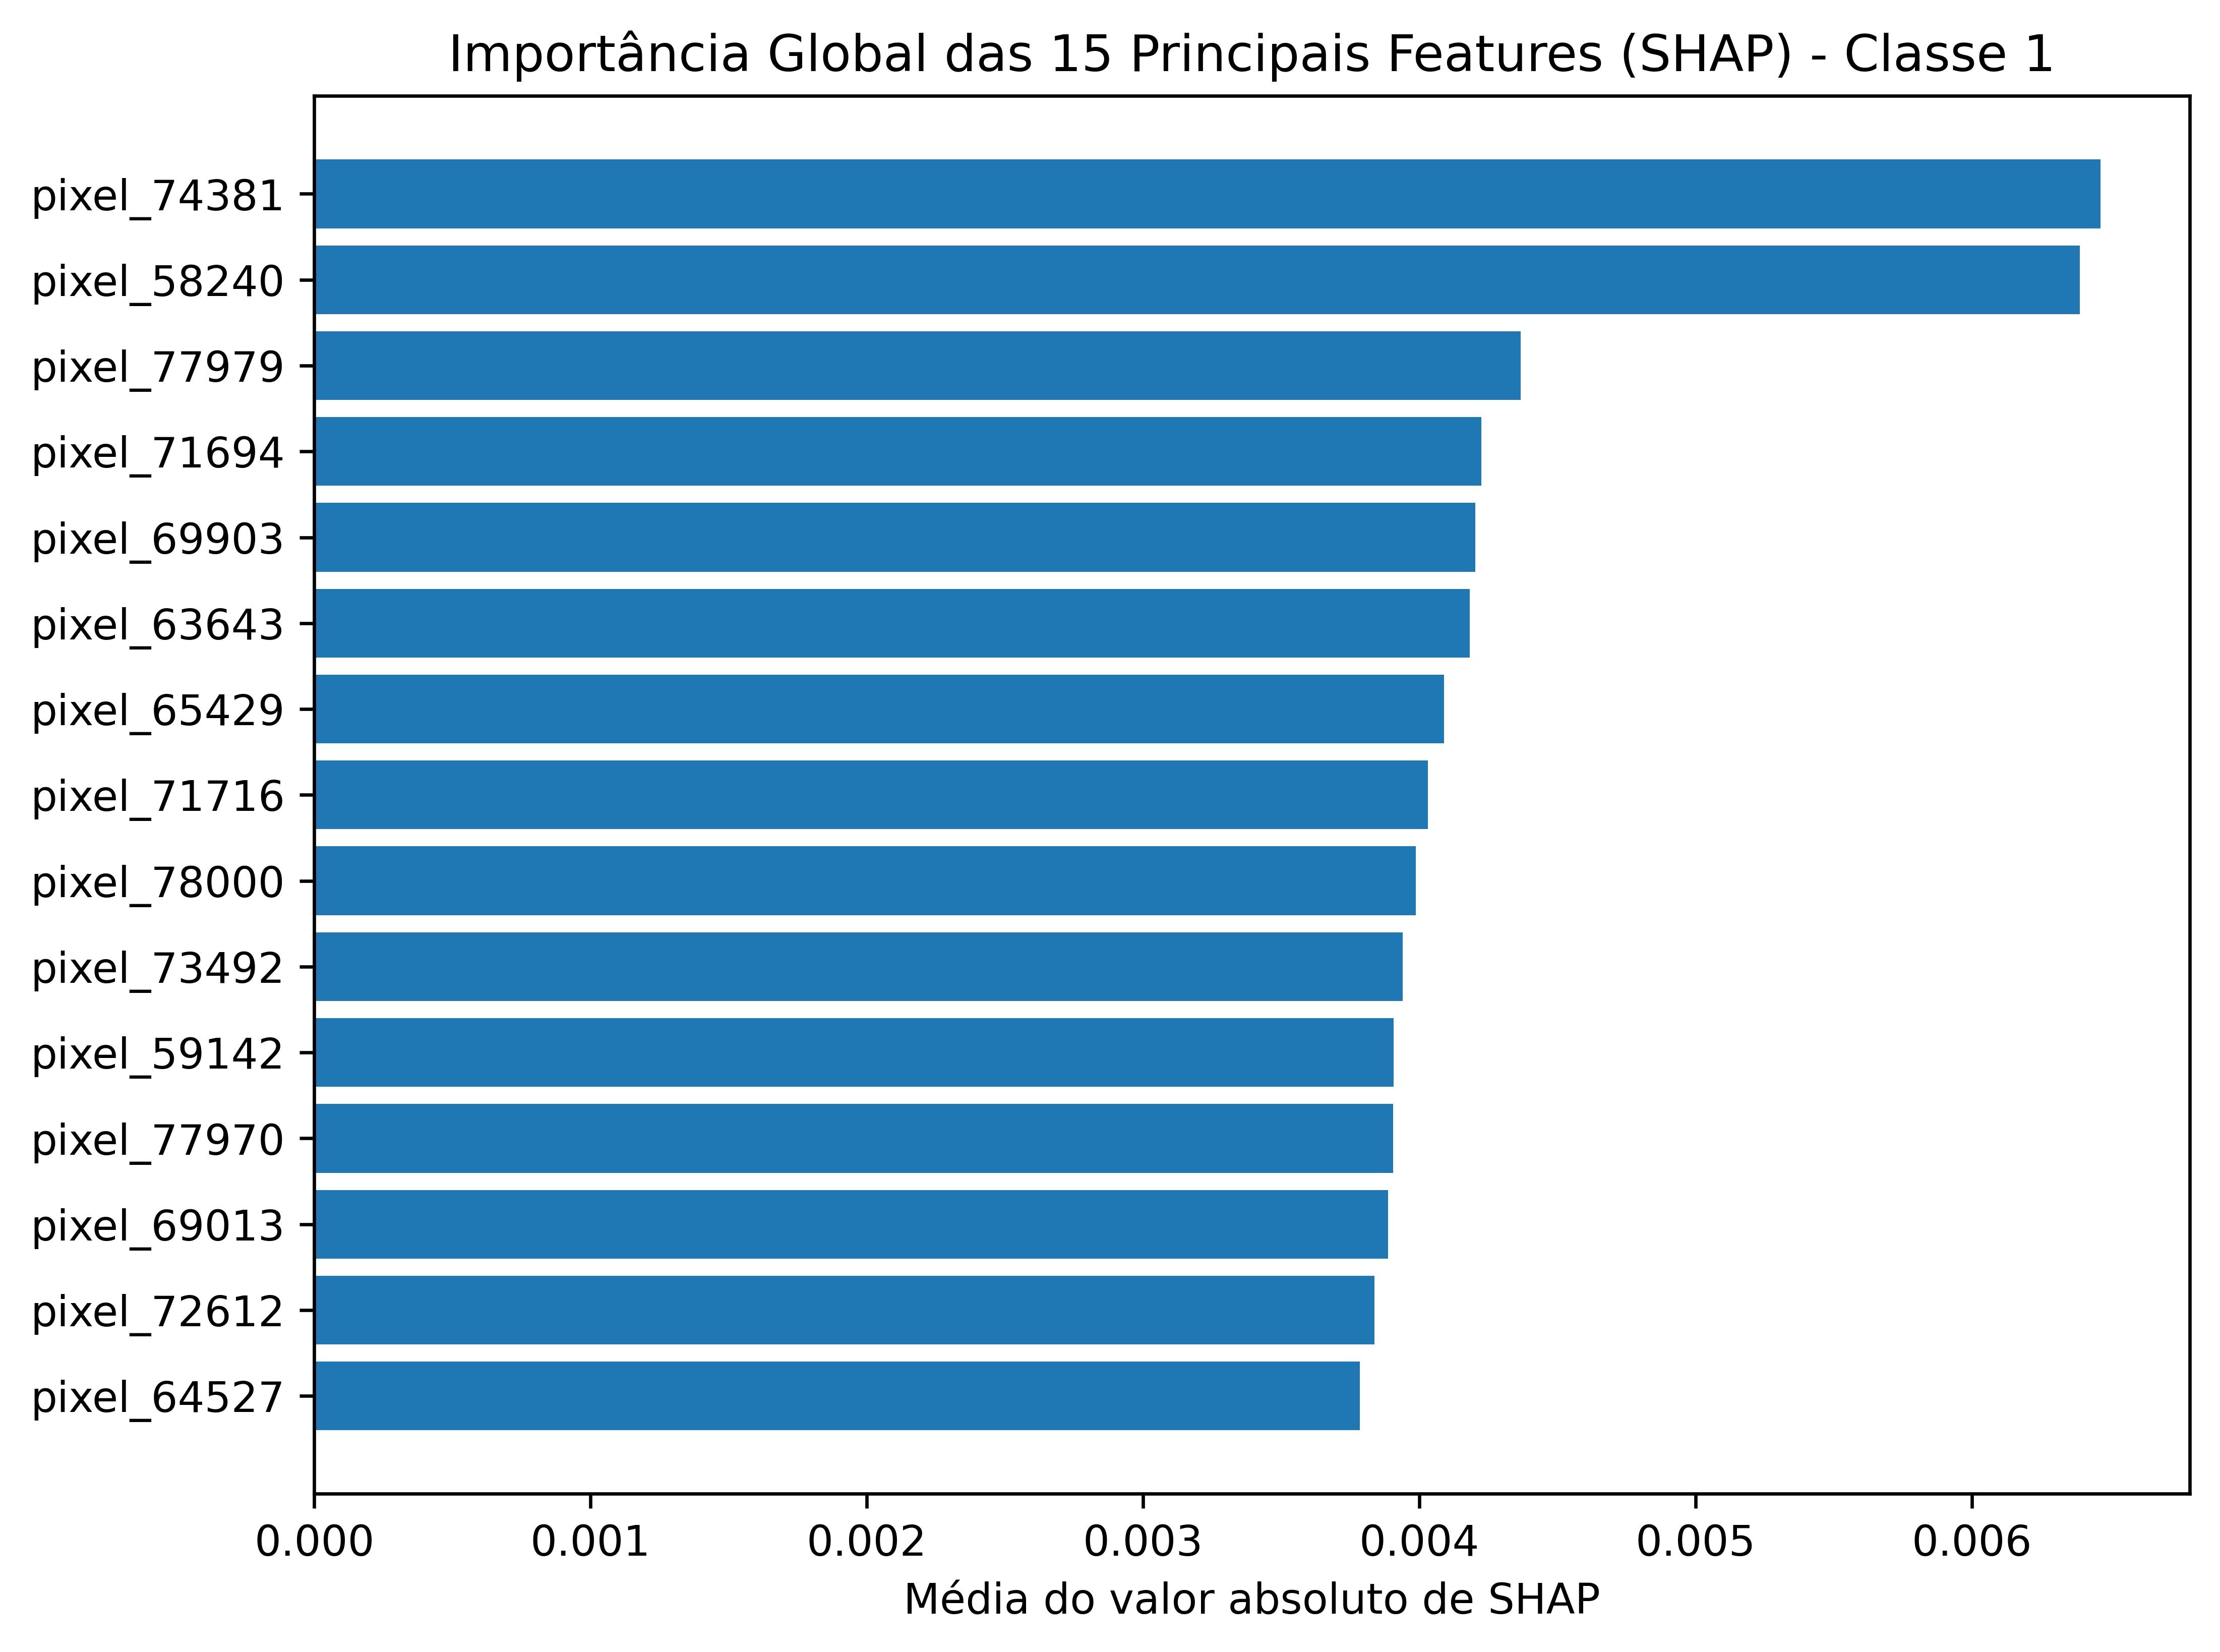

In [31]:
explainer = shap.TreeExplainer(RF_model)

shap_values = explainer(X_teste)
shap_values_class1 = shap_values[..., 1]  
mean_abs_shap = np.abs(shap_values_class1.values).mean(axis=0)
feature_names = [f"pixel_{i}" for i in range(len(mean_abs_shap))]


df_importance = pd.DataFrame({
    "Feature": feature_names,
    "Mean |SHAP|": mean_abs_shap
}).sort_values("Mean |SHAP|", ascending=False)

plt.figure(figsize=(8, 6))
plt.barh(df_importance["Feature"].head(15)[::-1], df_importance["Mean |SHAP|"].head(15)[::-1])
plt.title("Importância Global das 15 Principais Features (SHAP) - Classe 1")
plt.xlabel("Média do valor absoluto de SHAP")
plt.show()

##### Importância Média SHAP por filtro

In [32]:
tamanho = 128
n_filtros = 7
nomes_filtros = ["Valor de pixel", "Galbor 1", "Galbor 2", "Galbor 3", "Galbor 4", "Farid", "Unsharp"]

heatmaps = mean_abs_shap.reshape((tamanho, tamanho, n_filtros))

heatmaps_sem_pixel = heatmaps[..., 1:]
nomes_sem_pixel = nomes_filtros[1:]

fig, axes = plt.subplots(2, 3, figsize=(10, 7))
axes = axes.flatten()

for i in range(len(nomes_sem_pixel)):
    ax = axes[i]
    im = ax.imshow(heatmaps_sem_pixel[..., i], cmap='hot')
    ax.set_title(f"Filtro: {nomes_sem_pixel[i]}")
    ax.axis('off')
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

plt.suptitle("Importância média |SHAP| por filtro (sem valor de pixel)", fontsize=14)
plt.tight_layout()
plt.show()




In [33]:
tamanho = 128
n_filtros = 7
nomes_filtros = ["Valor de pixel", "Galbor 1", "Galbor 2", "Galbor 3", "Galbor 4", "Farid", "Unsharp"]

heatmaps = mean_abs_shap.reshape((tamanho, tamanho, n_filtros))

# heatmaps_sem_pixel = heatmaps[..., 1:]
# nomes_sem_pixel = nomes_filtros[1:]

fig, axes = plt.subplots(2, 4, figsize=(12, 7))
axes = axes.flatten()

for i in range(len(nomes_filtros)):
    ax = axes[i]
    im = ax.imshow(heatmaps[..., i], cmap='hot')
    ax.set_title(f"Filtro: {nomes_filtros[i]}")
    ax.axis('off')
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

plt.suptitle("Importância média |SHAP| por filtro (sem valor de pixel)", fontsize=14)
plt.tight_layout()
plt.show()

##### Distribuição da importância média dos pixels para diferentes filtros

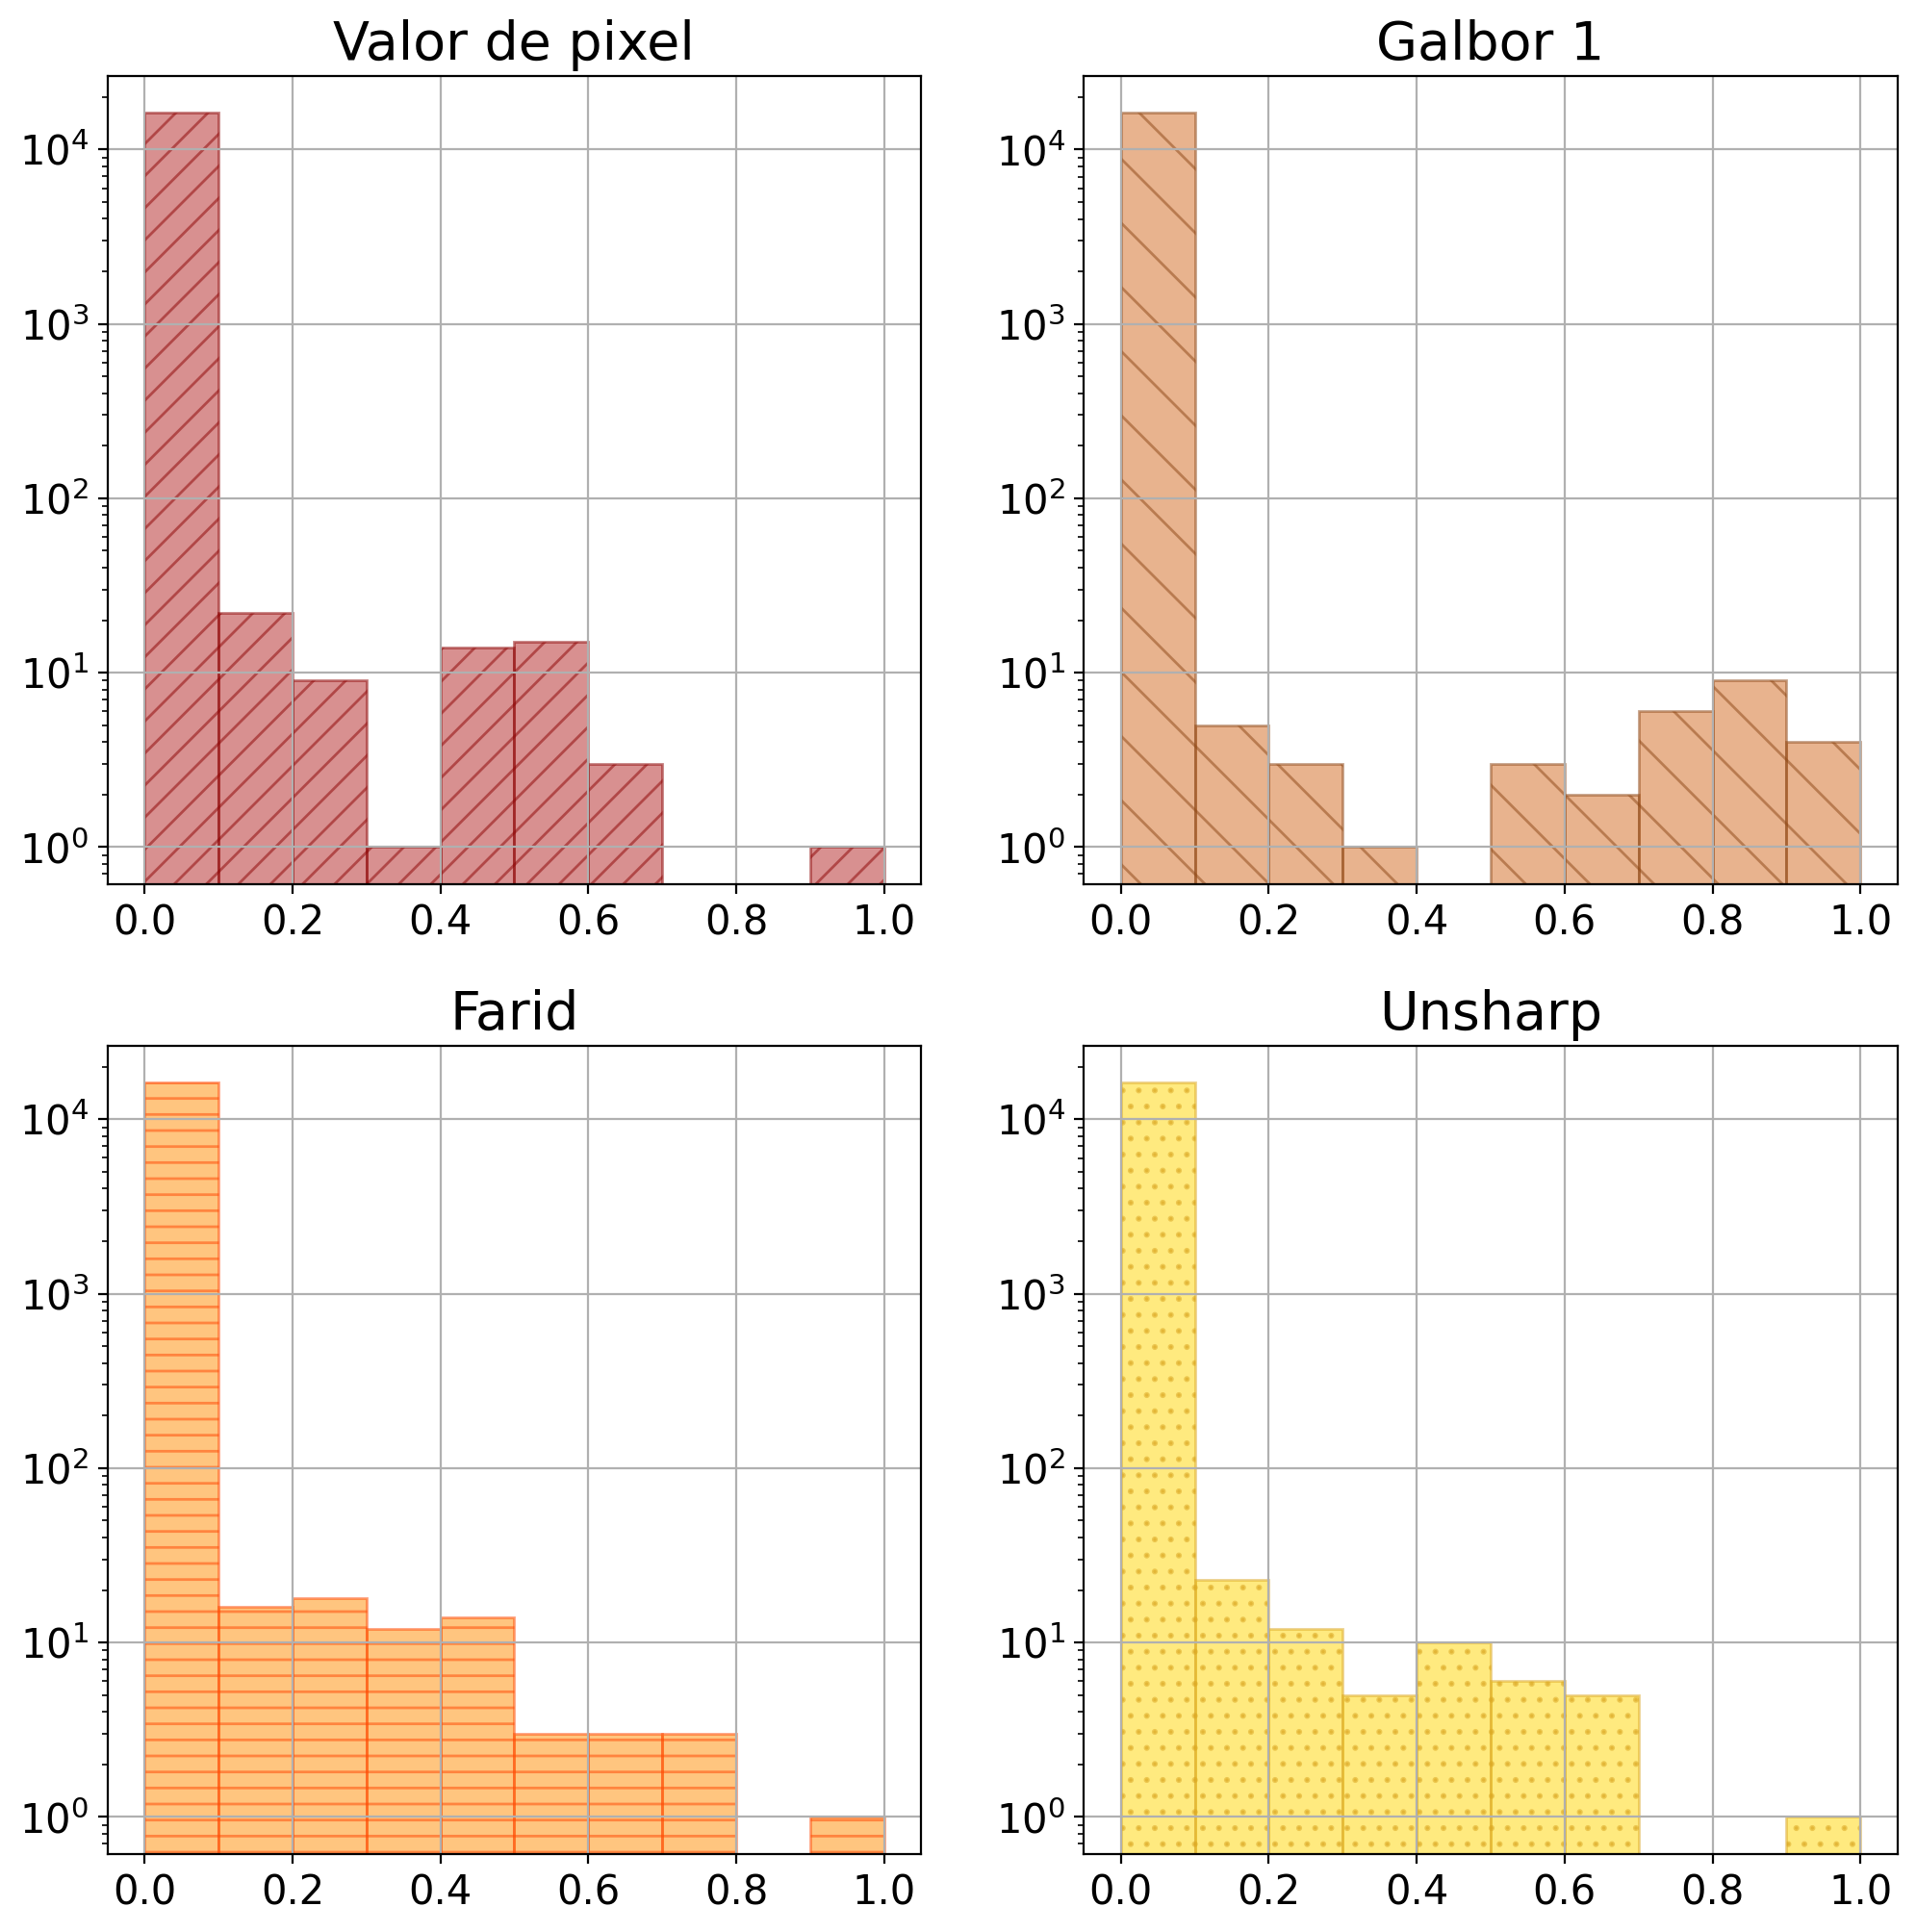

In [35]:
heatmaps = mean_abs_shap.reshape((tamanho, tamanho, n_filtros))

vp = heatmaps[:,:,0].reshape(-1)
g1 = heatmaps[:,:,1].reshape(-1)
far = heatmaps[:,:,5].reshape(-1)
unsh = heatmaps[:,:,6].reshape(-1)

vp = [i/max(vp) for i in vp]
g1 = [i/max(g1) for i in g1]
far = [i/max(far) for i in  far]
unsh = [i/max(unsh) for i in unsh]

#bins = np.arange(0, 0.0045 + 0.0001, 0.0001)

fig, ax = plt.subplots(2, 2, figsize=(12, 12), dpi=200)
ax = ax.flatten()

ax[0].hist(vp, log=True, color='firebrick', edgecolor='darkred', alpha=0.5, hatch="//", label="Valor de pixel")
ax[0].grid()
ax[0].set_title("Valor de pixel", fontsize=20)
ax[0].tick_params(axis='both', labelsize=15)

ax[1].hist(g1, log=True, color='chocolate', edgecolor='saddlebrown', alpha=0.5, hatch="\\", label = "Galbor1")
ax[1].grid()
ax[1].set_title("Galbor 1", fontsize=20)
ax[1].tick_params(axis='both', labelsize=15)

ax[2].hist(far, log=True, color='darkorange', edgecolor='orangered', alpha=0.5, hatch="--", label="Farid")
ax[2].grid()
ax[2].set_title("Farid", fontsize=20)
ax[2].tick_params(axis='both', labelsize=15)

ax[3].hist(unsh, log=True, color='gold', edgecolor='goldenrod', alpha=0.5, hatch="..", label="Unsharp")
ax[3].grid()
ax[3].set_title("Unsharp", fontsize=20)
ax[3].tick_params(axis='both', labelsize=15)

plt.show()